# Finetune ResNet50


With 1000 x 400 melspectrogram images without data augmentation


In [ ]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time
from PIL import Image

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [ ]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50'

train_csv = '../../data/melspectrogram_train_dataset.csv'
test_csv = '../../data/melspectrogram_test_dataset.csv'
root_dir = '../../data/'

Custom dataset class for loading the precomputed tensors of the mel spectrogram images


In [ ]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [ ]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the testing/evaluation function


In [ ]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100

    return test_loss, test_accuracy

Define what happens in each epoch


In [ ]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Check if current model is best performing using test_accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)),
             test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [ ]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [ ]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.66it/s, Loss=1.1866035461425781, Elapsed=56.1954s, ETA=0.0000s] 


Epoch 1 completed in 79.4439s
Train Loss: 1.4018215731729435 - Train Accuracy: 45.30560557193454
Test Loss: 1.304891617611201 - Test Accuracy: 49.63197467352592

Epoch 2/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.75it/s, Loss=1.1020503044128418, Elapsed=55.6311s, ETA=0.0000s] 


Epoch 2 completed in 78.9284s
Train Loss: 1.2606700028045268 - Train Accuracy: 50.94877223530343
Test Loss: 1.2388259208563603 - Test Accuracy: 51.49188761377127

Epoch 3/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.71it/s, Loss=1.2353522777557373, Elapsed=56.0759s, ETA=0.0000s] 


Epoch 3 completed in 79.6358s
Train Loss: 1.2289433648314656 - Train Accuracy: 51.815429668177046
Test Loss: 1.2419490910539723 - Test Accuracy: 51.6818361693708

Epoch 4/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.69it/s, Loss=1.3338035345077515, Elapsed=55.9764s, ETA=0.0000s] 


Epoch 4 completed in 79.2801s
Train Loss: 1.2022508581982383 - Train Accuracy: 53.305368131541975
Test Loss: 1.2585010805515329 - Test Accuracy: 50.41551246537396

Epoch 5/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.76it/s, Loss=1.0321041345596313, Elapsed=55.4779s, ETA=0.0000s] 


Epoch 5 completed in 78.6568s
Train Loss: 1.1854499930067908 - Train Accuracy: 54.04736935831734
Test Loss: 1.2156542924919513 - Test Accuracy: 52.62366442421844

Epoch 6/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.75it/s, Loss=1.2207015752792358, Elapsed=55.5061s, ETA=0.0000s] 


Epoch 6 completed in 78.5789s
Train Loss: 1.1703401256211197 - Train Accuracy: 54.54995152258652
Test Loss: 1.192934513092041 - Test Accuracy: 53.95330431341512

Epoch 7/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.74it/s, Loss=1.2401524782180786, Elapsed=55.6570s, ETA=0.0000s] 


Epoch 7 completed in 78.8209s
Train Loss: 1.1629626311833345 - Train Accuracy: 55.07825639605058
Test Loss: 1.201519787913621 - Test Accuracy: 53.692125049465766

Epoch 8/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.76it/s, Loss=1.1425650119781494, Elapsed=55.3926s, ETA=0.0000s] 


Epoch 8 completed in 78.6579s
Train Loss: 1.151985745339454 - Train Accuracy: 55.6204119590811
Test Loss: 1.2143828302922874 - Test Accuracy: 52.18836565096952

Epoch 9/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.73it/s, Loss=1.1321388483047485, Elapsed=55.4940s, ETA=0.0000s] 


Epoch 9 completed in 78.5814s
Train Loss: 1.1433822726901572 - Train Accuracy: 55.65998535784246
Test Loss: 1.1640825873673564 - Test Accuracy: 55.045508508112384

Epoch 10/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.71it/s, Loss=1.0396937131881714, Elapsed=55.6258s, ETA=0.0000s] 


Epoch 10 completed in 78.6905s
Train Loss: 1.1355912428867967 - Train Accuracy: 56.376263875422936
Test Loss: 1.160880931700119 - Test Accuracy: 55.15631183221211

Epoch 11/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.75it/s, Loss=1.1664698123931885, Elapsed=55.4366s, ETA=0.0000s] 


Epoch 11 completed in 78.4579s
Train Loss: 1.127940001970605 - Train Accuracy: 56.44947466313144
Test Loss: 1.1611085943501405 - Test Accuracy: 55.74198654531064

Epoch 12/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.75it/s, Loss=0.9760538339614868, Elapsed=55.4709s, ETA=0.0000s] 


Epoch 12 completed in 78.5305s
Train Loss: 1.1191538032097152 - Train Accuracy: 56.78782722254101
Test Loss: 1.1804764349051196 - Test Accuracy: 54.21448357736446

Epoch 13/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.76it/s, Loss=1.2639988660812378, Elapsed=55.3995s, ETA=0.0000s] 


Epoch 13 completed in 78.2801s
Train Loss: 1.1143315223198902 - Train Accuracy: 57.276558697243715
Test Loss: 1.1438343524932861 - Test Accuracy: 55.575781559161065

Epoch 14/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.71it/s, Loss=1.1679457426071167, Elapsed=55.6610s, ETA=0.0000s] 


Epoch 14 completed in 79.2703s
Train Loss: 1.1040465407733675 - Train Accuracy: 57.537743129068645
Test Loss: 1.1460380042442169 - Test Accuracy: 55.86070439256034

Epoch 15/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.68it/s, Loss=0.9955350756645203, Elapsed=56.3855s, ETA=0.0000s] 


Epoch 15 completed in 80.0626s
Train Loss: 1.100053841403768 - Train Accuracy: 57.743524802627675
Test Loss: 1.1580586836795614 - Test Accuracy: 55.417491096161456

Epoch 16/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.73it/s, Loss=1.0376009941101074, Elapsed=55.6587s, ETA=0.0000s] 


Epoch 16 completed in 79.0291s
Train Loss: 1.09290617040441 - Train Accuracy: 58.131344110488925
Test Loss: 1.1576588177921796 - Test Accuracy: 55.92402057776019

Epoch 17/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.71it/s, Loss=0.9670427441596985, Elapsed=55.6891s, ETA=0.0000s] 


Epoch 17 completed in 78.7332s
Train Loss: 1.09682418696488 - Train Accuracy: 57.88401036823048
Test Loss: 1.139682488610046 - Test Accuracy: 55.86070439256034

Epoch 18/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.76it/s, Loss=1.1414844989776611, Elapsed=55.4689s, ETA=0.0000s] 


Epoch 18 completed in 78.7037s
Train Loss: 1.086110216907308 - Train Accuracy: 58.416272581570674
Test Loss: 1.1363199907119828 - Test Accuracy: 56.145627225959636

Epoch 19/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.75it/s, Loss=1.0707980394363403, Elapsed=55.4930s, ETA=0.0000s] 


Epoch 19 completed in 78.6830s
Train Loss: 1.0807853401461733 - Train Accuracy: 58.63194760482004
Test Loss: 1.131083891247258 - Test Accuracy: 56.683814800158295

Epoch 20/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.75it/s, Loss=1.002036452293396, Elapsed=55.5026s, ETA=0.0000s]  


Epoch 20 completed in 78.6261s
Train Loss: 1.0783769230299358 - Train Accuracy: 58.853558637883616
Test Loss: 1.1181819824257282 - Test Accuracy: 56.94499406410763

Epoch 21/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.75it/s, Loss=1.2106285095214844, Elapsed=55.5050s, ETA=0.0000s] 


Epoch 21 completed in 78.5679s
Train Loss: 1.0691974516156353 - Train Accuracy: 58.976236174043805
Test Loss: 1.134539165882149 - Test Accuracy: 56.818361693707956

Epoch 22/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.63it/s, Loss=1.1455680131912231, Elapsed=56.3598s, ETA=0.0000s] 


Epoch 22 completed in 79.5870s
Train Loss: 1.0674840586094916 - Train Accuracy: 59.061318981380715
Test Loss: 1.1611919180311339 - Test Accuracy: 55.868618915710336

Epoch 23/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.71it/s, Loss=1.08720064163208, Elapsed=56.0361s, ETA=0.0000s]   


Epoch 23 completed in 79.1738s
Train Loss: 1.0668278855613516 - Train Accuracy: 59.10089238014207
Test Loss: 1.172126885014351 - Test Accuracy: 55.654926790660866

Epoch 24/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.75it/s, Loss=0.9948285818099976, Elapsed=55.5197s, ETA=0.0000s] 


Epoch 24 completed in 78.7074s
Train Loss: 1.0655065874510175 - Train Accuracy: 59.26710065493975
Test Loss: 1.167806797557407 - Test Accuracy: 55.19588444796201

Epoch 25/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.74it/s, Loss=1.0313252210617065, Elapsed=55.7181s, ETA=0.0000s] 


Epoch 25 completed in 79.1728s
Train Loss: 1.054469033434421 - Train Accuracy: 59.66481331249134
Test Loss: 1.1264321773943275 - Test Accuracy: 56.660071230708354



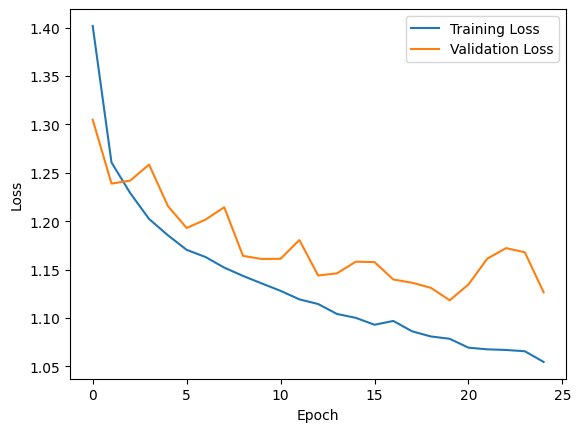

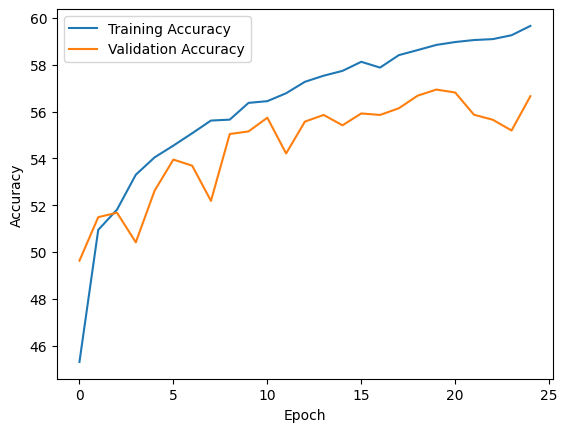

In [ ]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
    model, trainloader, testloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)

Plot confusion matrix


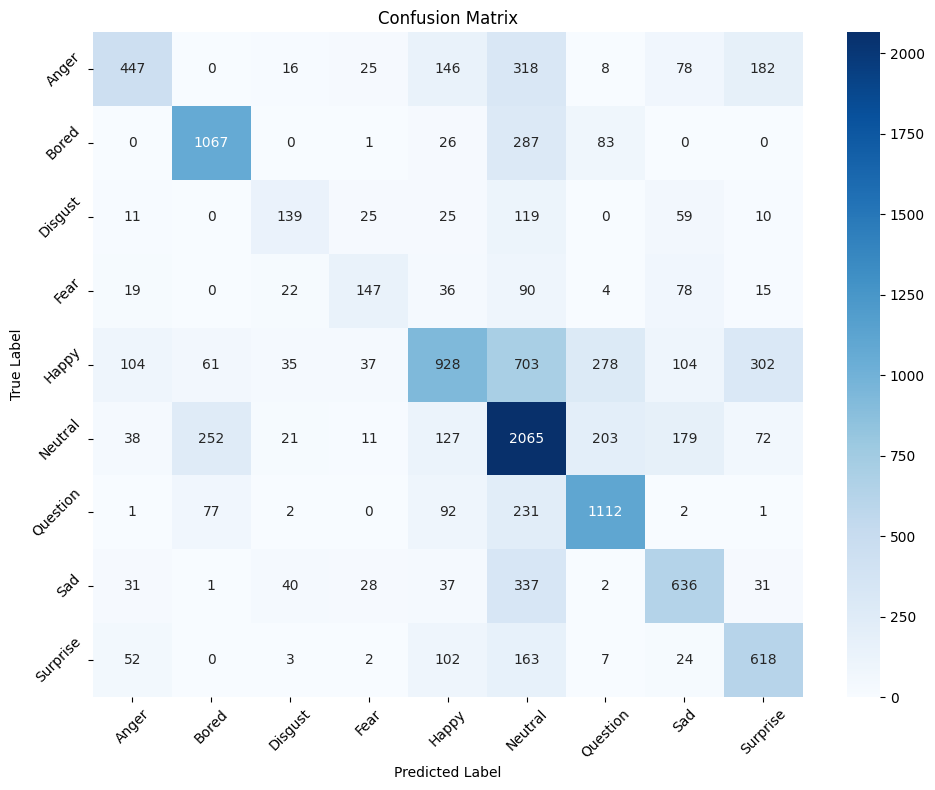

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()


# To use this function, collect predictions and true labels during testing
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)